In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
# !pip install evaluate
# !pip install seqeval

In [3]:
# !pip install accelerate -U
# !pip install transformers[torch]

In [ ]:
import sys
sys.path.append("..")
import helper
import json

from transformers import DistilBertTokenizer, BertTokenizer
from transformers import DataCollatorWithPadding
from transformers import TFDistilBertForSequenceClassification
from transformers import BertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from functools import partial

import torch
from torch import cuda
from itertools import chain, combinations
from collections import Counter
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

In [91]:
from sklearn.metrics import classification_report
import numpy as np

In [37]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

## Dataset

In [38]:
train_set = pd.read_json("../../data/subtask3/train_prepro.json")
valid_set = pd.read_json("../../data/subtask3/valid_prepro.json")
test_set = pd.read_json("../../data/subtask3/test_prepro.json")

### load id to label

In [42]:
with open("../../data/subtask3/label_to_id.json", "r") as f:
    relation_label_to_ID = json.load(f)
    ID_to_relation_label = {v:k for k, v in relation_label_to_ID.items()}

In [43]:
relation_label_to_ID

{'nil': 0,
 'Developer_of': 1,
 'Abbreviation_of': 2,
 'URL_of': 3,
 'Citation_of': 4,
 'Release_of': 5,
 'Version_of': 6,
 'Specification_of': 7,
 'Extension_of': 8,
 'PlugIn_of': 9,
 'AlternativeName_of': 10,
 'License_of': 11}

# Tokenizer

In [135]:
from transformers import BertTokenizerFast, AutoTokenizer

model_name = 'bert-base-uncased'
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [136]:
#test_set.label_binary

In [137]:
def prepare_sentence(sample):
    text = sample.context
    label = sample.label
    tokenized = tokenizer(text, truncation=True, padding="longest", max_length=512)
    tokenized["labels"] = sample.label
    return tokenized
train_tokenized = train_set.apply(prepare_sentence, axis=1).to_list()
valid_tokenized = valid_set.apply(prepare_sentence, axis=1).to_list()
test_tokenized = test_set.apply(prepare_sentence, axis=1).to_list()

In [138]:
len(train_tokenized), len(validation_tokenized), len(test_tokenized)

(4450, 1446, 960)

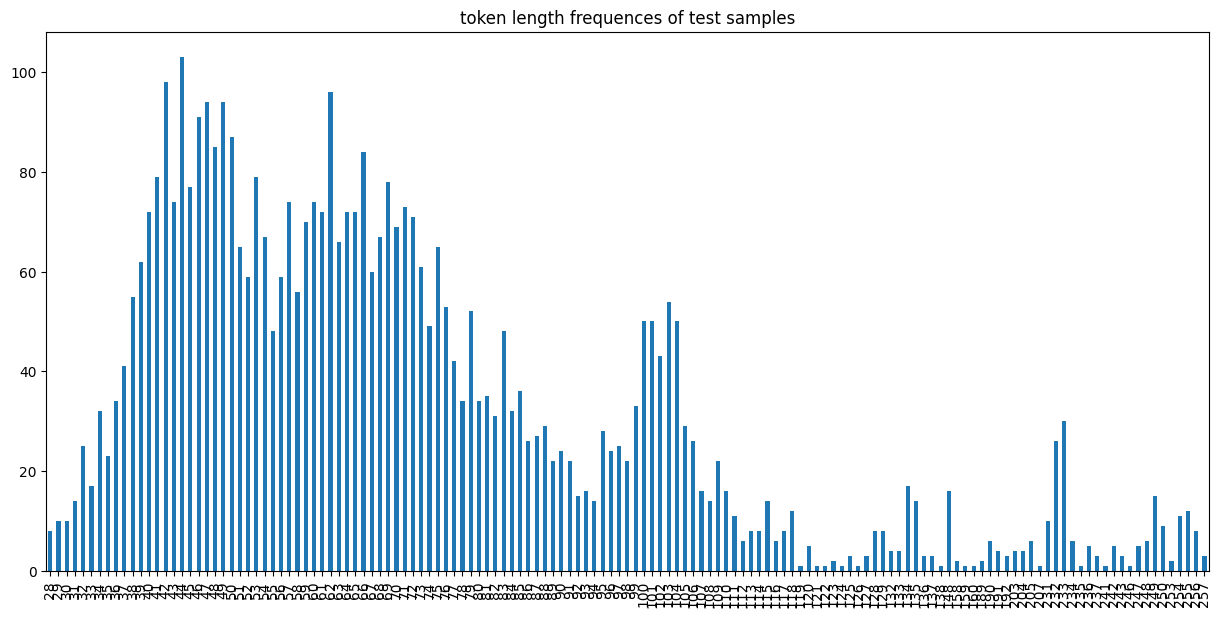

In [139]:
pd.Series([len(s["input_ids"]) for s in train_tokenized]).value_counts().sort_index().plot(kind="bar", figsize=(15,7), title="token length frequences of test samples");

# Evaluation

In [140]:
def compute_metrics(eval_preds, label_names):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    labels = [label_names[l] for l in labels]
    predictions = pd.Series([label_names[p] for p in predictions])
    n_predicted = predictions.value_counts().rename("n_predicted")
    metrics = precision_recall_fscore_support(labels, predictions, labels=label_names, zero_division=0)
    metrics = pd.DataFrame(metrics, index=["prec", "recall", "f1", "support"], columns=label_names).T
    f = metrics.index != "nil"
    metrics = metrics[f].copy()
    ## weighted f1
    weights = metrics.support / metrics.support.sum()
    metrics = metrics.join(n_predicted)
    metrics["n_predicted"] = metrics.n_predicted.fillna(0)
    metric_info = dict(
        eval_f1_macro_weighted = (metrics.f1 * weights).sum(),
        eval_support = metrics.support.sum(),
        eval_n_predicted = metrics.n_predicted.fillna(0).sum()
    )
    for label, row in metrics.iterrows():
        for metr, value in row.to_dict().items():
            metric_info[f"eval_{metr}_{label}"] = value
    return metric_info

In [141]:
labels = list(relation_label_to_ID.keys())
labels

['nil',
 'Developer_of',
 'Abbreviation_of',
 'URL_of',
 'Citation_of',
 'Release_of',
 'Version_of',
 'Specification_of',
 'Extension_of',
 'PlugIn_of',
 'AlternativeName_of',
 'License_of']

# Fine-tuning

In [142]:
# !pip install transformers optuna dataset

In [145]:
import optuna
from transformers import Trainer, TrainingArguments, BertForTokenClassification
from transformers import DataCollatorForTokenClassification, DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer,
                                        padding="longest",
                                        max_length=512)
def model_init():
#     return DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(labels), return_dict=True)
    return BertForSequenceClassification.from_pretrained(model_name, num_labels=len(ID_to_relation_label), return_dict=True)



In [ ]:
def objective(trial):
    params_to_optimize = dict(
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True),
        per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [2, 4, 8, 16]),
        #per_device_eval_batch_size = trial.suggest_categorical('val_batch_size', [4, 8, 16, 32])
        num_train_epochs = trial.suggest_int("num_train_epochs", 3, 8),
        weight_decay = trial.suggest_float("weight_decay",  1e-5, 0.1, log=True),
    )
    print(params_to_optimize)
    training_args = dict(
        output_dir="./result",
        evaluation_strategy="epoch",
        #learning_rate=learning_rate,
        #per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        #num_train_epochs=num_train_epochs,
        #weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=100,
        warmup_ratio=0.1,
        gradient_accumulation_steps=4,
        max_grad_norm=1.0
    )
    training_args |= params_to_optimize

    trainer = Trainer(
        model_init=model_init,
        args=TrainingArguments(**training_args),
        train_dataset=train_tokenized,
        eval_dataset=valid_tokenized,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, label_names=labels)
    )

    trainer.train()

    eval_result = trainer.evaluate()
    overall_f1 = eval_result['eval_f1_macro_weighted']
    return overall_f1

study = optuna.create_study(direction='maximize')
assert len(study.trials) == 0
study.optimize(objective, n_trials=20)

if len(study.trials) == 0 or all([t.state != optuna.trial.TrialState.COMPLETE for t in study.trials]):
    print("No trials are completed yet.")
else:
  print("Best trial:")
  trial = study.best_trial
  print(trial.values)
  print("Best hyperparameters: {}".format(trial.params))

[I 2024-07-27 16:10:54,141] A new study created in memory with name: no-name-1a4a85cd-2c9a-4348-9593-be7d3e9df9fa


{'learning_rate': 2.7633897354310153e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.00035724091869789845}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro Weighted,Support,N Predicted,Prec Developer Of,Recall Developer Of,F1 Developer Of,Support Developer Of,N Predicted Developer Of,Prec Abbreviation Of,Recall Abbreviation Of,F1 Abbreviation Of,Support Abbreviation Of,N Predicted Abbreviation Of,Prec Url Of,Recall Url Of,F1 Url Of,Support Url Of,N Predicted Url Of,Prec Citation Of,Recall Citation Of,F1 Citation Of,Support Citation Of,N Predicted Citation Of,Prec Release Of,Recall Release Of,F1 Release Of,Support Release Of,N Predicted Release Of,Prec Version Of,Recall Version Of,F1 Version Of,Support Version Of,N Predicted Version Of,Prec Specification Of,Recall Specification Of,F1 Specification Of,Support Specification Of,N Predicted Specification Of,Prec Extension Of,Recall Extension Of,F1 Extension Of,Support Extension Of,N Predicted Extension Of,Prec Plugin Of,Recall Plugin Of,F1 Plugin Of,Support Plugin Of,N Predicted Plugin Of,Prec Alternativename Of,Recall Alternativename Of,F1 Alternativename Of,Support Alternativename Of,N Predicted Alternativename Of,Prec License Of,Recall License Of,F1 License Of,Support License Of,N Predicted License Of
0,1.333000,0.626741,0.716721,668.000000,874.000000,0.688596,0.902299,0.781095,174.000000,228.000000,1.000000,0.833333,0.909091,6.000000,5.000000,0.656250,0.344262,0.451613,61.000000,32.000000,0.575000,1.000000,0.730159,92.000000,160.000000,0.625000,0.937500,0.750000,16.000000,24.000000,0.649315,0.959514,0.774510,247.000000,365.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.800000,0.615385,0.695652,13.000000,10.000000,0.658537,0.964286,0.782609,28.000000,41.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.888889,0.800000,0.842105,10.000000,9.000000
1,0.641900,0.556162,0.751791,668.000000,850,0.829787,0.672414,0.742857,174.000000,141.000000,0.666667,1.000000,0.800000,6.000000,9.000000,0.578313,0.786885,0.666667,61.000000,83.000000,0.585526,0.967391,0.729508,92.000000,152.000000,0.640000,1.000000,0.780488,16.000000,25.000000,0.664789,0.955466,0.784053,247.000000,355.000000,0.615385,0.444444,0.516129,18.000000,13.000000,0.590909,1.000000,0.742857,13.000000,22.000000,0.729730,0.964286,0.830769,28.000000,37.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.900000,0.900000,0.900000,10.000000,10.000000
2,0.460900,0.462374,0.765183,668.000000,663,0.782828,0.890805,0.833333,174.000000,198.000000,0.857143,1.000000,0.923077,6.000000,7.000000,0.750000,0.590164,0.660550,61.000000,48.000000,0.774648,0.597826,0.674847,92.000000,71.000000,0.800000,0.750000,0.774194,16.000000,15.000000,0.782427,0.757085,0.769547,247.000000,239.000000,0.625000,0.555556,0.588235,18.000000,16.000000,0.590909,1.000000,0.742857,13.000000,22.000000,0.750000,0.964286,0.843750,28.000000,36.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.800000,0.888889,10.000000,8.000000


In [28]:
print("Best trial:")
trial = study.best_trial
print(trial.values)
print("Best hyperparameters: {}".format(trial.params))

Best trial:
[0.8675686952464972]
Best hyperparameters: {'learning_rate': 3.4761989793610213e-05, 'train_batch_size': 2, 'num_train_epochs': 8, 'weight_decay': 0.00021383997220875088}


In [ ]:
#train_dataset = sorted(train_dataset, key=lambda x: len(x["input_ids"]))
#len(train_dataset[0]["input_ids"]), len(train_dataset[-1]["input_ids"])

In [68]:
best_params = {'learning_rate': 3.4761989793610213e-05, 'per_device_train_batch_size': 2, 'num_train_epochs': 8, 'weight_decay': 0.00021383997220875088}

In [69]:
training_args = dict(
        output_dir="./result",
        evaluation_strategy="epoch",
        learning_rate=4e-05,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=1e-5,
        logging_dir='./logs',
        logging_steps=100,
        warmup_ratio=0.1,
        gradient_accumulation_steps=2,
        max_grad_norm=1.0
    )
training_args |= best_params

trainer = Trainer(
        model_init=model_init,
        args=TrainingArguments(**training_args),
        train_dataset=train_tokenized,
        eval_dataset=valid_tokenized,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, label_names=labels)
    )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.model.id_

In [ ]:
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1 Macro Weighted,Support,N Predicted,Prec Developer Of,Recall Developer Of,F1 Developer Of,Support Developer Of,N Predicted Developer Of,Prec Abbreviation Of,Recall Abbreviation Of,F1 Abbreviation Of,Support Abbreviation Of,N Predicted Abbreviation Of,Prec Url Of,Recall Url Of,F1 Url Of,Support Url Of,N Predicted Url Of,Prec Citation Of,Recall Citation Of,F1 Citation Of,Support Citation Of,N Predicted Citation Of,Prec Release Of,Recall Release Of,F1 Release Of,Support Release Of,N Predicted Release Of,Prec Version Of,Recall Version Of,F1 Version Of,Support Version Of,N Predicted Version Of,Prec Specification Of,Recall Specification Of,F1 Specification Of,Support Specification Of,N Predicted Specification Of,Prec Extension Of,Recall Extension Of,F1 Extension Of,Support Extension Of,N Predicted Extension Of,Prec Plugin Of,Recall Plugin Of,F1 Plugin Of,Support Plugin Of,N Predicted Plugin Of,Prec Alternativename Of,Recall Alternativename Of,F1 Alternativename Of,Support Alternativename Of,N Predicted Alternativename Of,Prec License Of,Recall License Of,F1 License Of,Support License Of,N Predicted License Of
0,0.788900,0.666417,0.694501,668.000000,842.000000,0.707921,0.821839,0.760638,174.000000,202.000000,0.076923,0.166667,0.105263,6.000000,13.000000,0.505155,0.803279,0.620253,61.000000,97.000000,0.571429,1.000000,0.727273,92.000000,161.000000,0.592593,1.000000,0.744186,16.000000,27.000000,0.679739,0.842105,0.752260,247.000000,306.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.787879,0.928571,0.852459,28.000000,33.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.300000,0.461538,10.000000,3.000000
2,0.652700,0.547826,0.721061,668.000000,570.000000,0.825806,0.735632,0.778116,174.000000,155.000000,0.666667,1.000000,0.800000,6.000000,9.000000,0.732143,0.672131,0.700855,61.000000,56.000000,0.734940,0.663043,0.697143,92.000000,83.000000,0.684211,0.812500,0.742857,16.000000,19.000000,0.842391,0.627530,0.719258,247.000000,184.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.619048,1.000000,0.764706,13.000000,21.000000,0.787879,0.928571,0.852459,28.000000,33.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.700000,0.823529,10.000000,7.000000
4,0.414600,0.632555,0.777707,668.000000,770,0.732456,0.959770,0.830846,174.000000,228.000000,1.000000,1.000000,1.000000,6.000000,6.000000,0.569767,0.803279,0.666667,61.000000,86.000000,0.762500,0.663043,0.709302,92.000000,80.000000,0.592593,1.000000,0.744186,16.000000,27.000000,0.765799,0.834008,0.798450,247.000000,269.000000,0.583333,0.388889,0.466667,18.000000,12.000000,0.900000,0.692308,0.782609,13.000000,10.000000,0.750000,0.964286,0.843750,28.000000,36.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.769231,1.000000,0.869565,10.000000,13.000000
6,0.355500,0.486372,0.859057,668.000000,649,0.884146,0.833333,0.857988,174.000000,164.000000,1.000000,1.000000,1.000000,6.000000,6.000000,0.814815,0.721311,0.765217,61.000000,54.000000,0.860465,0.804348,0.831461,92.000000,86.000000,0.882353,0.937500,0.909091,16.000000,17.000000,0.887597,0.927126,0.906931,247.000000,258.000000,0.777778,0.388889,0.518519,18.000000,9.000000,1.000000,0.692308,0.818182,13.000000,9.000000,0.794118,0.964286,0.870968,28.000000,34.000000,1.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.900000,0.947368,10.000000,9.000000
7,0.235600,0.530890,0.865263,668.000000,683,0.862637,0.902299,0.882022,174.000000,182.000000,1.000000,1.000000,1.000000,6.000000,6.000000,0.796296,0.704918,0.747826,61.000000,54.000000,0.829787,0.847826,0.838710,92.000000,94.000000,0.888889,1.000000,0.941176,16.000000,18.000000,0.881679,0.935223,0.907662,247.000000,262.000000,0.777778,0.388889,0.518519,18.000000,9.000000,1.000000,0.692308,0.818182,13.000000,9.000000,0.771429,0.964286,0.857143,28.000000,35.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.909091,1.000000,0.952381,10.000000,11.000000


TrainOutput(global_step=8896, training_loss=0.5537357971393805, metrics={'train_runtime': 1223.6267, 'train_samples_per_second': 29.094, 'train_steps_per_second': 7.27, 'total_flos': 1790951158387440.0, 'train_loss': 0.5537357971393805, 'epoch': 7.9964044943820225})

In [ ]:
test_performance = trainer.evaluate(eval_dataset=test_tokenized)

In [ ]:
test_performance = pd.Series(test_performance)

In [83]:
test_performance.eval_f1_macro_weighted

0.7965889913566564

In [ ]:
test_prediction = [ID_to_relation_label[l] for l in trainer.predict(test_dataset=test_tokenized).label_ids]

In [ ]:
prediction_report = trainer.predict(test_dataset=test_tokenized)
predictions = np.argmax(prediction_report.predictions, axis=1)
predictions_label = [ID_to_relation_label[l] for l in predictions]

In [ ]:
labels = [
    'Version_of',
    'Developer_of',
    'Citation_of',
    'URL_of',
    'PlugIn_of',
    'Specification_of',
    'Release_of',
    'Extension_of',
    'License_of',    
    'Abbreviation_of',
    'AlternativeName_of',
]

In [103]:
test_metrics = pd.DataFrame(classification_report(test_set["relation"], predictions_label, zero_division=0., labels=labels, output_dict=True)).T

In [104]:
test_metrics.to_json("experiment_bert_base_uncased/test_performance.json", orient="records")

In [ ]:
with open("experiment_bert_base_uncased/best_params.json", "w") as f:
    json.dump(best_params, f)

In [106]:
with open("experiment_bert_base_uncased/training_params.json", "w") as f:
    json.dump(training_args, f)

In [ ]:
test_set['prediction_label'] = predictions_label

In [113]:
test_set.prediction_label

0        License_of
1            URL_of
2            URL_of
3        Version_of
4               nil
           ...     
955    Developer_of
956      Release_of
957             nil
958             nil
959             nil
Name: prediction_label, Length: 960, dtype: object

In [129]:
f = test_set.prediction_label != 'nil'
def rels_to_string(rels):
    rel_strings = rels.apply(lambda rel: f"{rel.prediction_label}\t{rel.subject_begin}\t{rel.object_begin}", axis=1)
    rels_string = ";".join(rel_strings.to_list()) 
    return rels_string
pred_formated_dict = test_set[f].groupby("sentence_id").apply(rels_to_string).to_dict()
len(pred_formated_dict)

/tmp/ipykernel_2606477/2319769929.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred_formated_dict = test_set[f].groupby("sentence_id").apply(rels_to_string).to_dict()


126

In [132]:
sent_ids = sorted(test_set.sentence_id.unique())
pred_formatted = [pred_formated_dict.get(idx, "") for idx in sent_ids]
pred_text = "\n".join(pred_formatted)
len(pred_formatted)

130

In [133]:
with open("experiment_bert_base_uncased/prediction.txt", "w") as f:\
    f.write(pred_text)